In [ ]:
# site="https://mirrors.tuna.tsinghua.edu.cn/CRAN"
# install.packages(c("WGCNA", "stringr", "reshape2"), repos=site)
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("preprocessCore")
library(WGCNA)

In [24]:
library(WGCNA)
library(reshape2)
library(stringr)
library(dplyr)
library(limma)
options(stringsAsFactors = FALSE)
rm(list = ls())
#enableWGCNAThreads()
setwd("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/WGCNA/test_data")
# 读取数据
input_f <- "TPM_test.txt"
df <- read.table(input_f, sep="\t", head=TRUE, row.names=1)
tissues <- c( 'Anther1', 'Anther2', 'Anther3', 'Cotyledon1', 'Cotyledon2', 'Cotyledon3', 'Ovule1', 'Ovule2', 'Ovule3',
            'Hypocotyl1', 'Hypocotyl2', 'Hypocotyl3', 'Leaf1', 'Leaf2', 'Leaf3', 'Petal1', 'Petal2', 'Petal3', 'Radicle1', 'Radicle2', 
            'Root1', 'Root2', 'Root3', 'Stem1', 'Stem2', 'Stem3', 'Stigma1', 'Stigma2', 'Stigma3', 'Fiber_10DPA1', 'Fiber_10DPA2', 'Fiber_20DPA1', 'Fiber_20DPA2')
df <- as.matrix(select(df, all_of(tissues)))
batch <- c(1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1)

# print(df)
# 去除批次效应
df <- removeBatchEffect(df, batch)
print(dim(df))

[1] 12313    33


In [37]:
# 数据清洗
df_mad <- apply(df, 1, mad) 

#df_Var <- df[which(df_mad>max(quantile(df_mad, probs=seq(0,1,0.25))[2], 0.01)),]
df_Var <- df[which(df_mad>max(quantile(df_mad, probs=seq(0,1,0.25))[1], 0)),]


In [38]:
## 转换格式，横纵转换
df_Var_t <- as.data.frame(t(df_Var))
#df_Var_t <- as.data.frame(t(df))

dim(df_Var_t)
gsg = goodSamplesGenes(df_Var_t, verbose = 3)
if (!gsg$allOK){
  # Optionally, print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
    printFlush(paste("Removing genes:", 
                     paste(names(df_Vart)[!gsg$goodGenes], collapse = ",")));
  if (sum(!gsg$goodSamples)>0) 
    printFlush(paste("Removing samples:", 
                     paste(rownames(df_Vart)[!gsg$goodSamples], collapse = ",")));
  # Remove the offending genes and samples from the data:
  df_Vart = df_Vart[gsg$goodSamples, gsg$goodGenes]
}
nGenes = ncol(df_Var_t)
nSamples = nrow(df_Var_t)
dim(df_Var_t)

[1]    33 11583

 Flagging genes and samples with too many missing values...
  ..step 1


[1]    33 11583

In [8]:
## 软阈值筛选，看是否存在离群值
pdf("J668_cluster.pdf")
sampleTree = hclust(dist(df_Var_t), method = "average")
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="")
dev.off()

png 
  2

In [9]:
powers = c(c(1:10), seq(from = 12, to=30, by=2))
type = "unsigned"
corType = "pearson"
corFnc = ifelse(corType=="pearson", cor, bicor)
maxPOutliers = ifelse(corType=="pearson",1,0.05)
sft = pickSoftThreshold(df_Var_t, powerVector=powers, networkType=type, verbose=5)

pickSoftThreshold: will use block size 4845.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4845 of 9234


Warning message:
"executing %dopar% sequentially: no parallel backend registered"


   ..working on genes 4846 through 9234 of 9234
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.81100  4.350          0.934 3140.00   3130.00 4510.0
2      2  0.43500  1.450          0.982 1530.00   1470.00 2840.0
3      3  0.00928  0.122          0.898  875.00    799.00 2000.0
4      4  0.26600 -0.584          0.899  553.00    478.00 1500.0
5      5  0.56400 -0.954          0.920  374.00    306.00 1180.0
6      6  0.70100 -1.150          0.939  265.00    205.00  949.0
7      7  0.76000 -1.290          0.943  195.00    143.00  782.0
8      8  0.78400 -1.380          0.941  148.00    102.00  656.0
9      9  0.80600 -1.450          0.945  115.00     75.20  558.0
10    10  0.82700 -1.480          0.957   90.70     56.40  480.0
11    12  0.82900 -1.570          0.954   59.50     33.30  367.0
12    14  0.85300 -1.600          0.968   41.00     20.60  288.0
13    16  0.85500 -1.640          0.971   29.40     13.30  231.0
14    18  0.86600 -1.660          0.978   

In [11]:
par(mfrow = c(1,2))
cex1 = 0.9
# 横轴是Soft threshold (power)，纵轴是无标度网络的评估参数，数值越高，
# 网络越符合无标度特征 (non-scale)
## 储存PDF 文件
pdf("soft_threshold_choose.pdf")
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
abline(h=0.85,col="red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, 
     cex=cex1, col="red")
dev.off()

png 
  2

In [12]:
power = sft$powerEstimate
power

[1] 14

In [13]:
## 经验poewer 选择（在没有能够满足条件的power时选取）
# 无向网络在power小于15或有向网络power小于30内，没有一个power值可以使
# 无标度网络图谱结构R^2达到0.8，平均连接度较高如在100以上，可能是由于
# 部分样品与其他样品差别太大。这可能由批次效应、样品异质性或实验条件对
# 表达影响太大等造成。可以通过绘制样品聚类查看分组信息和有无异常样品。
# 如果这确实是由有意义的生物变化引起的，也可以使用下面的经验power值。
if (is.na(power)){
  power = ifelse(nSamples<20, ifelse(type == "unsigned", 9, 18),
          ifelse(nSamples<30, ifelse(type == "unsigned", 8, 16),
          ifelse(nSamples<40, ifelse(type == "unsigned", 7, 14),
          ifelse(type == "unsigned", 6, 12))       
          )
          )
}

Warning message in is.na(power):
"is.na() applied to non-(list or vector) of type 'closure'"


In [13]:
##一步法网络构建：One-step network construction and module detection##
# power: 上一步计算的软阈值
# maxBlockSize: 计算机能处理的最大模块的基因数量 (默认5000)；
#  4G内存电脑可处理8000-10000个，16G内存电脑可以处理2万个，32G内存电脑可
#  以处理3万个
#  计算资源允许的情况下最好放在一个block里面。
# corType: pearson or bicor
# numericLabels: 返回数字而不是颜色作为模块的名字，后面可以再转换为颜色
# saveTOMs：最耗费时间的计算，存储起来，供后续使用
# mergeCutHeight: 合并模块的阈值，越大模块越少
# type = "unsigned"
# corType = "pearson"
#maxPOutliers = ifelse(corType=="pearson",1,0.05)
net = blockwiseModules(df_Var_t, power = power, maxBlockSize = nGenes,
                       TOMType = "unsigned", minModuleSize = 30,
                       reassignThreshold = 4, mergeCutHeight = 0.25,
                       numericLabels = TRUE, pamRespectsDendro = FALSE,
                       saveTOMs=TRUE, corType = "pearson", loadTOMs=TRUE,
                       saveTOMFileBase = paste0("J668_WGCNA", ".tom"),
                       verbose = 3)



 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file J668_WGCNA.tom-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
  ..reassigning 153 genes from module 1 to modules with higher KME.
  ..reassigning 148 genes from module 2 to modules with higher KME.
  ..reassigning 149 genes from module 3 to modules with higher KME.
  ..reassigning 105 genes from module 4 to modules with higher KME.
  ..reassigning 93 genes from module 5 to modules with higher KME.
  ..reassigning 139 genes from module 6 to modules with higher KME.
  ..reassigning 85 genes from module 7 to modul

In [51]:
ls(net)
class(net)
library(rlist)
#net$blockGenes
#class(net$blockGenes)
save.image("all.RData")

[1] "blockGenes"     "blocks"         "colors"         "dendrograms"   
 [5] "goodGenes"      "goodSamples"    "MEs"            "MEsOK"         
 [9] "TOMFiles"       "unmergedColors"

[1] "list"

In [71]:
setwd("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/WGCNA/test_data")
load('all.RData')
ls()

[1] "adjacency"        "Alldegrees1"      "batch"            "cex1"            
 [5] "colorlevels"      "connet"           "corFnc"           "corType"         
 [9] "datKME"           "df"               "df_mad"           "df_Var"          
[13] "df_Var_t"         "dissTOM"          "GeneSignificance" "GS1"             
[17] "gsg"              "i"                "input_f"          "k"               
[21] "keys"             "KIM"              "matx"             "maxPOutliers"    
[25] "ME"               "MEs"              "MM"               "moduleColors"    
[29] "net"              "nGenes"           "nSamples"         "outputf"         
[33] "plotTOM"          "power"            "powers"           "restrict1"       
[37] "sampleTree"       "sft"              "tissues"          "TOM"             
[41] "type"             "uniq_colors"      "which.module"     "whichmodule"     
[45] "z"

In [4]:

# <- load("J668_WGCNA.tom-block.1.RData")
#load(net$TOMFiles[1], verbose=T)
# 根据模块中基因数目的多少，降序排列，依次编号为 `1-最大模块数`。
# **0 (grey)**表示**未**分入任何模块的基因。 

table(net$colors)

## 
##   0   1   2   3   4   5   6   7   8   9  10  11  12  13 
## 135 472 356 333 307 303 177 158 102  94  69  66  63  62


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
 240 3639  713  564  420  396  384  364  309  237  236  230  221  207  204  166 
  16   17   18   19   20   21 
 158  146  119  109   94   78 

In [38]:
## ---- echo=T, fig.cap="层级聚类树展示各个模块"---------------------------
## 灰色的为**未分类**到模块的基因。
# Convert labels to colors for plotting
moduleLabels = net$colors
moduleColors = labels2colors(moduleLabels)
# Plot the dendrogram and the module colors underneath
# 如果对结果不满意，还可以recutBlockwiseTrees，节省计算时间
pdf(file="plotDendroAndColors.pdf", onefile=F, paper="special", 
    bg="white", pointsize=6)
plotDendroAndColors(net$dendrograms[[1]], moduleColors,
                    "Module colors",
                    dendroLabels = FALSE, hang = 0.5,
                    addGuide = TRUE, guideHang = 0.05)
dev.off()

png 
  2

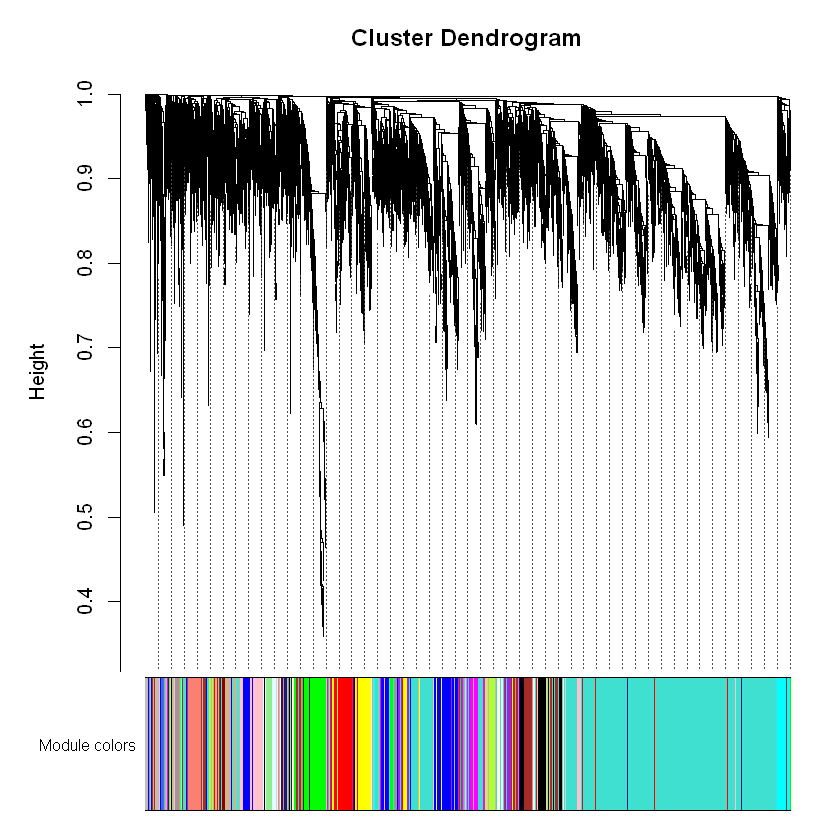

In [37]:
## 灰色的为**未分类**到模块的基因。
# Convert labels to colors for plotting
moduleLabels = net$colors
moduleColors = labels2colors(moduleLabels)
# Plot the dendrogram and the module colors underneath
# 如果对结果不满意，还可以recutBlockwiseTrees，节省计算时间
plotDendroAndColors(net$dendrograms[[1]], moduleColors[net$blockGenes[[1]]],
                    "Module colors",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

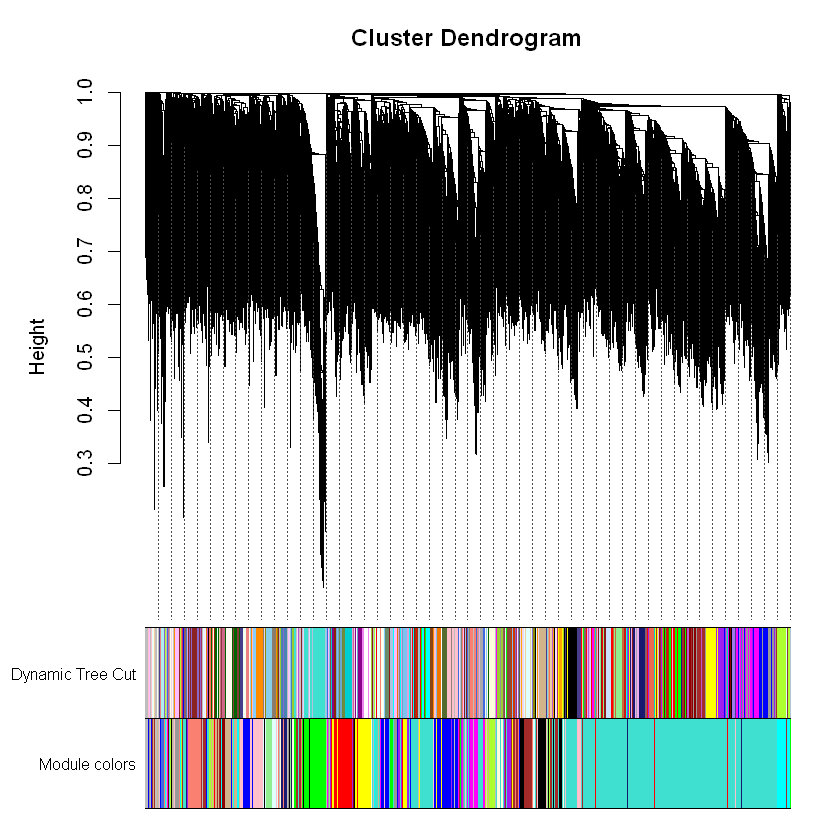

In [39]:
dynamicColors <- labels2colors(net$unmergedColors)
plotDendroAndColors(net$dendrograms[[1]], cbind(dynamicColors,moduleColors),
                    c("Dynamic Tree Cut", "Module colors"),
                    dendroLabels = FALSE, hang = 0.5,
                    addGuide = TRUE, guideHang = 0.05)

In [12]:
moduleColors <- labels2colors(net$colors)
uniq_colors <- unique(moduleColors)
nGenes = ncol(df)
nSamples = nrow(df)
#print(nGenes)
MEs <- moduleEigengenes(df_Var_t, moduleColors)$eigengenes
#print(moduleColors)
#sizeGrWindow(8,7)

for (i in uniq_colors){
    which.module=i
    outputf = paste(i, ".pdf", sep="")
    ME=MEs[, paste("ME",which.module, sep="")]
    pdf(outputf)
    par(mfrow=c(2,1), mar=c(0.3, 5.5, 3, 2))
    matx <- t(scale(df_Var_t[,moduleColors==which.module ]))
    plotMat(matx,
            nrgcols=30,rlabels=F,rcols=which.module,
            main=which.module, cex.main=2)
    par(mar=c(5, 4.2, 0, 0.7))
    barplot(ME, col=which.module, main="", cex.main=2,
            ylab="eigengene expression",xlab="MPP")
    dev.off()
} 
#print(ME)
# par(mfrow=c(2,1), mar=c(0.3, 5.5, 3, 2))
# matx <- t(scale(df_Var_t[,moduleColors==which.module ]))
# plotMat(matx)

# par(mar=c(5, 4.2, 0, 0.7))
# barplot(ME, col=which.module, main="", cex.main=2,
#         ylab="eigengene expression",xlab="MPP")

In [24]:
## 查找hub 网络
# 1、计算基因与模块间相关性

adjacency = adjacency(df_Var_t, power = power)
MM= as.data.frame(cor(df_Var_t, MEs, use ="p"))
#head(MM)
KIM = intramodularConnectivity(adjacency, moduleColors)

,MEblack,MEblue,MEbrown,MEcyan,MEdarkred,MEgreen,MEgreenyellow,MEgrey,MEgrey60,MElightcyan,⋯,MEmagenta,MEmidnightblue,MEpink,MEpurple,MEred,MEroyalblue,MEsalmon,MEtan,MEturquoise,MEyellow
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ghir_A01G000010,-0.03252493,0.66050323,-0.38080794,0.52823862,0.3073694,-0.45818867,0.337926714,-0.73935969,-0.35937329,0.34400529,⋯,0.606481055,0.2817957,-0.17357498,0.50535384,0.3184260,-0.3243485,0.194686186,0.1486201,0.79207003,0.2907248
Ghir_A01G000030,0.35389551,-0.03261634,0.02555937,0.30037444,0.2336325,-0.45396979,-0.035440944,0.20500426,0.31844660,0.01595501,⋯,-0.185461448,-0.3084904,0.18496361,0.15910156,0.3375602,-0.1192211,0.004654295,0.4240156,0.12065694,0.3586107
Ghir_A01G000050,0.63527897,0.08792245,-0.25676180,0.35517672,0.3067319,-0.63989540,-0.236929674,0.05651218,0.30714922,-0.14710146,⋯,-0.213826583,-0.1830965,0.45352438,0.23787462,0.5837095,0.2279138,0.168171572,0.2480942,0.50171371,0.5057961
Ghir_A01G000040,0.10324286,0.31942728,-0.19786034,0.68684489,0.2085315,-0.38185275,0.282276052,-0.37795399,-0.06448694,0.36543154,⋯,0.337937689,0.3682681,0.04321862,0.42783215,0.4477932,-0.2653793,0.526856285,0.1559355,0.82416425,0.1289336
Ghir_A01G000060,0.18620759,0.18106533,0.03868249,0.26972489,0.2867860,-0.27355191,0.002963513,-0.02249687,-0.06853812,0.21751648,⋯,0.007927214,-0.1563694,-0.13521142,0.34936222,0.6171484,-0.1502270,-0.143213429,0.6180256,0.08273447,0.4945442
Ghir_A01G000070,0.15480412,-0.07424988,-0.28562073,-0.04112632,-0.2588886,0.03940852,-0.066567896,-0.10972813,0.03163260,-0.12529000,⋯,0.193914269,0.3939462,0.39616528,-0.09241646,-0.2171992,-0.5491808,0.376892993,-0.5619977,0.46188494,-0.2745069


In [25]:
head(KIM)

,kTotal,kWithin,kOut,kDiff
,<dbl>,<dbl>,<dbl>,<dbl>
Ghir_A01G000010,56.0298206,51.910830,4.1189909,47.7918388
Ghir_A01G000030,0.3115014,0.103904,0.2075974,-0.1036934
Ghir_A01G000050,5.4157133,1.035378,4.3803349,-3.3449565
Ghir_A01G000040,73.2041877,71.190874,2.0133138,69.1775600
Ghir_A01G000060,1.2863963,0.588135,0.6982613,-0.1101263
Ghir_A01G000070,2.1559187,1.354885,0.8010336,0.5538516


In [21]:
datKME = signedKME(df_Var_t,MEs,outputColumnName="MM.")
head(datKME)

,MM.black,MM.blue,MM.brown,MM.cyan,MM.darkred,MM.green,MM.greenyellow,MM.grey,MM.grey60,MM.lightcyan,⋯,MM.magenta,MM.midnightblue,MM.pink,MM.purple,MM.red,MM.royalblue,MM.salmon,MM.tan,MM.turquoise,MM.yellow
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ghir_A01G000010,-0.03252493,0.66050323,-0.38080794,0.52823862,0.3073694,-0.45818867,0.337926714,-0.73935969,-0.35937329,0.34400529,⋯,0.606481055,0.2817957,-0.17357498,0.50535384,0.3184260,-0.3243485,0.194686186,0.1486201,0.79207003,0.2907248
Ghir_A01G000030,0.35389551,-0.03261634,0.02555937,0.30037444,0.2336325,-0.45396979,-0.035440944,0.20500426,0.31844660,0.01595501,⋯,-0.185461448,-0.3084904,0.18496361,0.15910156,0.3375602,-0.1192211,0.004654295,0.4240156,0.12065694,0.3586107
Ghir_A01G000050,0.63527897,0.08792245,-0.25676180,0.35517672,0.3067319,-0.63989540,-0.236929674,0.05651218,0.30714922,-0.14710146,⋯,-0.213826583,-0.1830965,0.45352438,0.23787462,0.5837095,0.2279138,0.168171572,0.2480942,0.50171371,0.5057961
Ghir_A01G000040,0.10324286,0.31942728,-0.19786034,0.68684489,0.2085315,-0.38185275,0.282276052,-0.37795399,-0.06448694,0.36543154,⋯,0.337937689,0.3682681,0.04321862,0.42783215,0.4477932,-0.2653793,0.526856285,0.1559355,0.82416425,0.1289336
Ghir_A01G000060,0.18620759,0.18106533,0.03868249,0.26972489,0.2867860,-0.27355191,0.002963513,-0.02249687,-0.06853812,0.21751648,⋯,0.007927214,-0.1563694,-0.13521142,0.34936222,0.6171484,-0.1502270,-0.143213429,0.6180256,0.08273447,0.4945442
Ghir_A01G000070,0.15480412,-0.07424988,-0.28562073,-0.04112632,-0.2588886,0.03940852,-0.066567896,-0.10972813,0.03163260,-0.12529000,⋯,0.193914269,0.3939462,0.39616528,-0.09241646,-0.2171992,-0.5491808,0.376892993,-0.5619977,0.46188494,-0.2745069


In [27]:
### Intramodular connectivity, module membership, and screening for intramodular hub genes

# (1) Intramodular connectivity
moduleColors <- labels2colors(net$colors)
connet=abs(cor(df_Var_t,use="p"))^6
Alldegrees1=intramodularConnectivity(connet, moduleColors)
#head(Alldegrees1)



In [68]:
# (2) Relationship between gene significance and intramodular connectivity
which.module="black"

MM= as.data.frame(cor(df_Var_t, MEs, use ="p"))
#head(MM)
# GS1 = cor(df_Var_t, MEs, use="p")
# head(GS1)
# GeneSignificance=abs(GS1)
colorlevels=unique(moduleColors)
sizeGrWindow(9,6)
par(mfrow=c(2,as.integer(0.5+length(colorlevels)/2)))
par(mar = c(4,5,3,1))
par(mar = c(1, 1, 1, 1))
#dim(Alldegrees1$kWithin[restrict1])
for (i in c(1:14))
{
  whichmodule=colorlevels[[i]];
  restrict1 = (moduleColors==whichmodule);
  keys = paste("ME", whichmodule, sep="")
  #print(keys)
  print(length(Alldegrees1$kWithin[restrict1]))
  print(length(MM[, i][restrict1]))
  k <- verboseScatterplot(Alldegrees1$kWithin[restrict1],
                     MM[, i][restrict1], col=moduleColors[restrict1],
                     main=whichmodule,
                     xlab = "Connectivity", ylab = "Gene Significance", abline = TRUE)
}


[1] 3639
[1] 3639
[1] 420
[1] 420
[1] 364
[1] 364
[1] 384
[1] 384
[1] 240
[1] 240
[1] 309
[1] 309
[1] 221
[1] 221
[1] 564
[1] 564
[1] 713
[1] 713
[1] 236
[1] 236
[1] 207
[1] 207
[1] 109
[1] 109
[1] 396
[1] 396
[1] 158
[1] 158


In [74]:
hubs = chooseTopHubInEachModule(df_Var_t, colorh=moduleColors, power=power, type=type)


black              blue             brown              cyan 
"Ghir_A13G004380" "Ghir_A11G014110" "Ghir_A11G004330" "Ghir_D01G006300" 
          darkred             green       greenyellow            grey60 
"Ghir_A13G021750" "Ghir_A13G017470" "Ghir_D01G010280" "Ghir_A12G026960" 
        lightcyan        lightgreen       lightyellow           magenta 
"Ghir_A13G023570" "Ghir_A13G011300" "Ghir_A13G009120" "Ghir_A13G002210" 
     midnightblue              pink            purple               red 
"Ghir_A13G003900" "Ghir_A12G020890" "Ghir_A13G003520" "Ghir_D01G014840" 
        royalblue            salmon               tan         turquoise 
"Ghir_D01G005140" "Ghir_A13G022810" "Ghir_A13G018320" "Ghir_A11G026600" 
           yellow 
"Ghir_A01G016500"

In [79]:

con <- nearestNeighborConnectivity(df_Var_t, nNeighbors=50, power=power,
                                   type=type, corFnc = "bicor")

 nearestNeighborConnectivity: selecting sample pool of size 5000 ..
 nearestNeighborConnectivity: received dataset with nGenes = 9234
 ..using nNeighbors = 50 and blockSize = 1000     


,kTotal,kWithin,kOut,kDiff
,<dbl>,<dbl>,<dbl>,<dbl>
Ghir_A01G000010,56.0298206,51.91082974,4.1189909,47.7918388
Ghir_A01G000030,0.3115014,0.10390397,0.2075974,-0.1036934
Ghir_A01G000050,5.4157133,1.03537839,4.3803349,-3.3449565
Ghir_A01G000040,73.2041877,71.19087388,2.0133138,69.1775600
Ghir_A01G000060,1.2863963,0.58813499,0.6982613,-0.1101263
Ghir_A01G000070,2.1559187,1.35488511,0.8010336,0.5538516
Ghir_A01G000080,0.5014243,0.05016625,0.4512580,-0.4010918
Ghir_A01G000090,8.6331737,6.70493936,1.9282343,4.7767051
Ghir_A01G000100,183.4464228,181.27806751,2.1683553,179.1097122


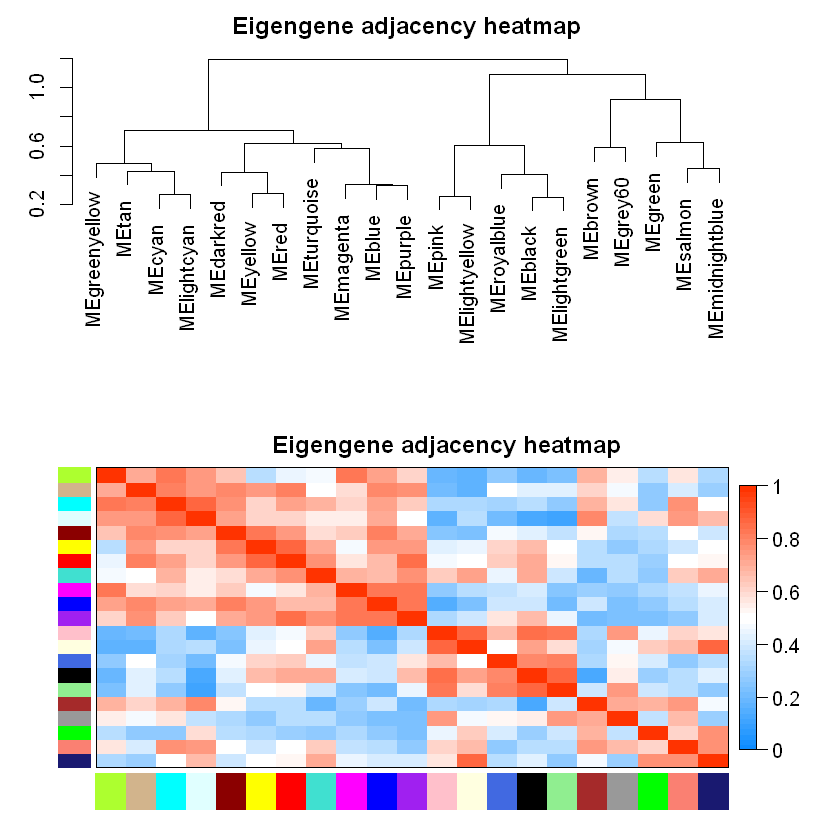

In [40]:
# module eigengene, 可以绘制线图，作为每个模块的基因表达趋势的展示
MEs = net$MEs

### 不需要重新计算，改下列名字就好
### 官方教程是重新计算的，起始可以不用这么麻烦
MEs_col = MEs
colnames(MEs_col) = paste0("ME", labels2colors(
  as.numeric(str_replace_all(colnames(MEs),"ME",""))))
MEs_col = orderMEs(MEs_col)

# 根据基因间表达量进行聚类所得到的各模块间的相关性图
# marDendro/marHeatmap 设置下、左、上、右的边距
plotEigengeneNetworks(MEs_col, "Eigengene adjacency heatmap", 
                      marDendro = c(3,3,2,4),
                      marHeatmap = c(3,4,2,2), plotDendrograms = T, 
                      xLabelsAngle = 90)

Loading objects:
  TOM


Warning message in min(dendro$height):
"no non-missing arguments to min; returning Inf"
Warning message in max(dendro$height):
"no non-missing arguments to max; returning -Inf"
Warning message in min(dendro$height):
"no non-missing arguments to min; returning Inf"


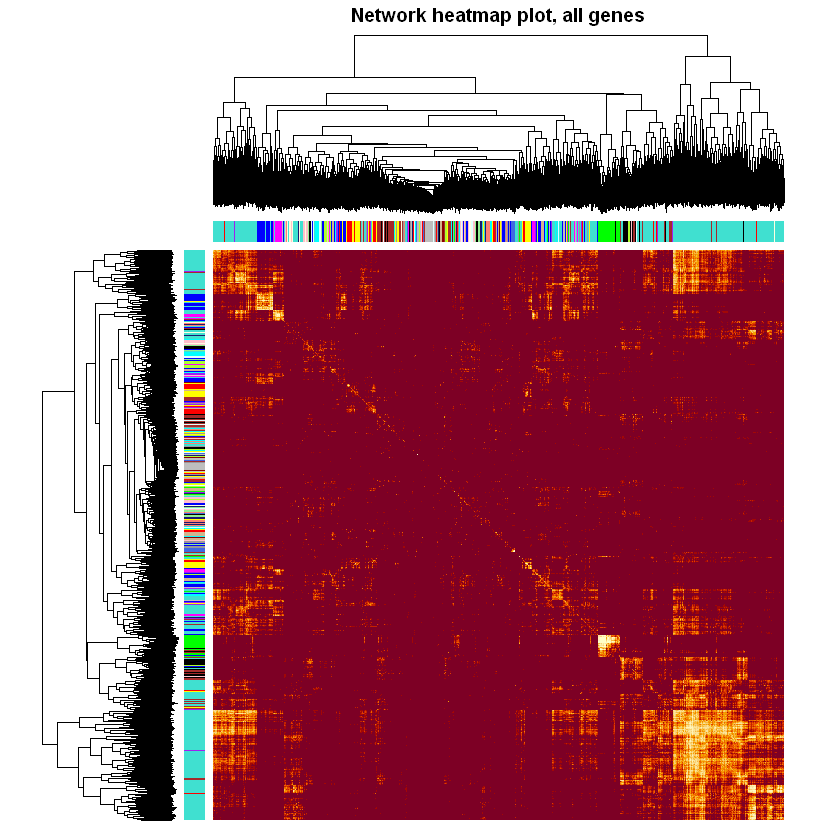

In [9]:
# 如果采用分步计算，或设置的blocksize>=总基因数，直接load计算好的TOM结果
# 否则需要再计算一遍，比较耗费时间
# TOM = TOMsimilarityFromExpr(dataExpr, power=power, corType=corType, networkType=type)
load(net$TOMFiles[1], verbose=T)

## Loading objects:
##   TOM

TOM <- as.matrix(TOM)

dissTOM = 1-TOM
# Transform dissTOM with a power to make moderately strong 
# connections more visible in the heatmap
plotTOM = dissTOM^7
# Set diagonal to NA for a nicer plot
diag(plotTOM) = NA
# Call the plot function
moduleColors <- labels2colors(net$colors)

# 这一部分特别耗时，行列同时做层级聚类
TOMplot(plotTOM, net$dendrograms, moduleColors, 
        main = "Network heatmap plot, all genes")

In [24]:
probes = colnames(df_Var_t)
dimnames(TOM) <- list(probes, probes)

# Export the network into edge and node list files Cytoscape can read
# threshold 默认为0.5, 可以根据自己的需要调整，也可以都导出后在
# cytoscape中再调整
cyt = exportNetworkToCytoscape(TOM,
             edgeFile = paste("J668_WGCNA", ".edges.txt", sep=""),
             nodeFile = paste("J668_WGCNA", ".nodes.txt", sep=""),
             weighted = TRUE, threshold = 0,
             nodeNames = probes, nodeAttr = moduleColors)